# Data Cleaning and Preprocessing

In [1]:
# Imports #
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from IPython.display import display
# Exploration #
#import seaborn as sns
#from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import LogisticRegression

In [2]:
# Data #
df = 'Sample_PFF_Data.csv'
df = pd.read_csv(df)

#### The data will be cleaned and processed by focusing on true plays where it's reasonable for the offense to run or pass. Plays like kickoffs and plays that didn't have an R or P values for column RUNPASS are removed from the dataset.
#### Plays where the column POAACTUAL is QB Fumble or QB Kneel were also removed because to me these are not true run plays because a qb fumble could come on a designed pass play and a qb kneel is not a play the offense uses to try to advance position on the defense.
#### Because the question is concerned with predicting the next play, variables that are available to us prior to the snap of the ball is what I am concerned with. While using other variables like how many yards were gained on the play, where the drive ended on the field, and direction of the run/pass would likely improve accuracy of the model I didn't see them as valuable in this scenario because we want to predict what the play will be before the ball is snapped not after.

In [3]:
# Clean and Process the dataframe #
clean_df = df.dropna(subset=['RUNPASS']).reset_index(drop=True)
clean_df = clean_df[clean_df['RUNPASS'] != 'X']
clean_df = clean_df.dropna(subset=['DRIVE']).reset_index(drop=True)
# Other play types to eliminate #
clean_df = clean_df[~clean_df['POAACTUAL'].isin(['QB FUMBLE', 'QB KNEEL'])]
# Columns to keep in the dataframe #
keep_cols = ['DEFPERSONNEL', 'DEFSUBSTITUTIONS', 'DISTANCE', 'DOWN', 'DRIVEPLAY',
             'DRIVESTARTFIELDPOSITION', 'FIELDPOSITION', 'GAINLOSSNET' , 'GARBAGETIME',
             'HASH', 'MOFOCSHOWN', 'OFFPERSONNELBASIC', 'OFFFORMATIONUNBALANCED' ,
             'OFFSUBSTITUTIONS', 'RBSINBACKFIELD' , 'QBRESET', 'TRICKLOOK' ,
             'QUARTER', 'SCOREDIFFERENTIAL', 'SHOTGUN', 'SHIFTMOTION', 'TEALIGNMENT',
             'OffTeam', 'DefTeam', 'PLAYID','PREVIOUSPFFPLAYID', '2MINUTE',
             'DRIVESTARTEVENT', 'RUNPASS']
clean_df = clean_df[keep_cols]
# Fill cols w 0s that need them #
clean_df['RBSINBACKFIELD'].fillna(0, inplace=True)

#### The data I have chosen to consider for this scenario is grouped into several broad categories.
#### Game Situation - These variables are relevant because the constraints of the rules and a given situation are influential in what play is likely to be called.
- DISTANCE, DOWN, DRIVEPLAY, DRIVESTARTFIELDPOSITION, FIELDPOSITION, GAINLOSSNET, GARBAGETIME, QUARTER, SCOREDIEFFERENTIAL, 2MINUTE, DRIVESTARTEVENT
#### Team Alignment - These variables are relevant for assessing how the team lines up can indicate the resulting play call.
- DEFPERSONNEL, DEFSUBSTITUTIONS, HASH, MOFOCSHOWN, OFFPERSONNELBASIC, OFFFORMATIONUNBALANCED ,OFFSUBSTITUTIONS, RBSINBACKFIELD , QBRESET, TRICKLOOK, SHOTGUN, SHIFTMOTION, TEALIGNMENT, OffTeam, DefTeam,
#### Misc - These variables were used to help calculate additional factors.
- PLAYID, PREVIOUSPFFPLAYID
#### It is possible that I misunderstood what some of these variables meant but my intent was to only consider variables that are available prior to the start of a play. I started building my model with primarily game situation factors and added the alignment factors as I iterated and attempted to improve accuracy.

# Feature Engineering
#### Some features I found useful to add to the dataset is the result of net yards gained on the previous play as well as if the previous play was a run or a pass.
#### If a play was the first play of the drive or didn't have a previous play to reference I set the value of net yards gained to 0, assuming the approach to a likely 1st and 10 situation would be similar to the approach on 2nd and 10 which also occurs after 0 net yards gained on a play.

In [4]:
# Add features #
# Change in Field Position from Previous Play #
play_to_fieldposition = clean_df.set_index('PLAYID')['GAINLOSSNET']
clean_df['PREVIOUS_FIELDPOSITION_CHANGE'] = clean_df['PREVIOUSPFFPLAYID'].map(
    play_to_fieldposition)
clean_df['PREVIOUS_FIELDPOSITION_CHANGE'].fillna(0, inplace=True)
# R/P of Previous Play #
play_to_runpass = clean_df.set_index('PLAYID')['RUNPASS']
clean_df['PREVIOUS_RUNPASS'] = clean_df['PREVIOUSPFFPLAYID'].map(play_to_runpass)

### Create Additional Factors:
#### Some other features I added to the dataset is grouping the distance to a first down into short, medium, and long sections. I choose these groupings based on hoping to roughly split the dataset into 3 even groups based on 10 yards being the typical length to a first down. Obviously a huge amount of the plays occur on 1st and 10 but besides that I think these groupings are balanced.
#### Short: 1-3 yards to go
#### Medium: 4-7 yards to go
#### Long: 8+ yards to go
#### Next the score differentials were grouped based on the max points scored with one possession being 8. This score combined with time constraints of a game will likely be influential for strategy.
#### Set 7 groupings of either tied, and up or down by 1,2,3+ scores
#### A variable was also created from the offensive personnel column that totaled how many RBs or TEs were on the field for a given play. This was a way to reduce the number of possible combinations since many personnel groupings were available.

In [5]:
# Yardage Groupings #
clean_df['DISTANCE_GROUPS'] = clean_df['DISTANCE'].apply(
    lambda x: 'short' if x in [1, 2, 3]
    else 'medium' if x in [4, 5, 6, 7,] else 'long')
# Score Groupings #
clean_df['SCORE_GROUPS'] = clean_df['SCOREDIFFERENTIAL'].apply(
    lambda x: 'tie' if x == 0
    else '1 score' if 0 < x < 9
    else '2 score' if 8 < x < 17
    else '-1 score' if -9 < x < 0
    else '-2 score' if -17 < x < -8
    else '-3 score' if x < -16 else '3 score')

In [6]:
# Personnel Groupings #
clean_df[['RB', 'TE', 'EXTRA']] = clean_df['OFFPERSONNELBASIC'].str.extract(
    r'(\d)(\d)(?: \((.*?)\))?').fillna(0)
clean_df['RB_TE_sum'] = clean_df['RB'].astype(int) + clean_df['TE'].astype(int)

# Exploratory Analysis

#### Group by team

In [7]:
team_df = clean_df.groupby(
    ['OffTeam'])['RUNPASS'].value_counts().unstack().reset_index()
team_df.rename(columns={'P': 'COUNT_P', 'R': 'COUNT_R'}, inplace=True)
team_df['P%'] = (team_df['COUNT_P'] / (team_df['COUNT_P'] + team_df['COUNT_R'])) * 100
team_df['R%'] = 100 - team_df['P%']
print("Pass Frequency:")
team_df['P%'].describe()

Pass Frequency:


count    32.000000
mean     62.094882
std       3.977675
min      54.084967
25%      59.163705
50%      62.464979
75%      65.488364
max      68.953688
Name: P%, dtype: float64

In [8]:
print("Run Frequency:")
team_df['R%'].describe()

Run Frequency:


count    32.000000
mean     37.905118
std       3.977675
min      31.046312
25%      34.511636
50%      37.535021
75%      40.836295
max      45.915033
Name: R%, dtype: float64

#### As part of my beginning analysis I looked at the run/pass diet when grouped by all teams. An average of 61.14% of a teams plays are pass plays. The rest are run plays. The team that runs the ball the most still averages around 54% of its play as passes in this dataset.

#### Group by down

In [9]:
down_df = clean_df.groupby(
    ['DOWN'])['RUNPASS'].value_counts().unstack().reset_index()
down_df.rename(columns={'P': 'COUNT_P', 'R': 'COUNT_R'}, inplace=True)
down_df['P%'] = (down_df['COUNT_P'] / (down_df['COUNT_P'] + down_df['COUNT_R'])) * 100
down_df['R%'] = 100 - down_df['P%']
down_df['plays_on_down'] = down_df['COUNT_R'] + down_df['COUNT_P']
total_plays = clean_df.shape[0]
down_df['DOWN_FREQ%'] = (down_df['plays_on_down'] / total_plays) * 100
display(down_df[['DOWN', 'P%', 'R%', 'DOWN_FREQ%']].style.hide_index())

DOWN,P%,R%,DOWN_FREQ%
1,52.221708,47.778292,44.754013
2,62.788145,37.211855,33.024340
3,82.401443,17.598557,20.098395
4,65.609756,34.390244,2.123252


#### Looking at all downs, it is clear that the down is very influential in the type of play.
#### On first down teams run 47.78% of the time. This is greater than the percentage of the most run heavy team average in the dataset.
#### On second down the percentage of passes at 62.79% is very similar to the league average among all teams in the dataset.
#### On third down there's a dramatic increase in pass percentage to 82.40%.
#### Plays on fourth down make up a very small percentage of overall plays, they hold a distribution slightly more pass heavy than a team average.

#### Group by yardage

In [10]:
distance_df = clean_df.groupby(
    ['DISTANCE_GROUPS'])['RUNPASS'].value_counts().unstack().reset_index()
distance_df.rename(columns={'P': 'COUNT_P', 'R': 'COUNT_R'}, inplace=True)
distance_df['P%'] = (distance_df['COUNT_P'] /
                     (distance_df['COUNT_P'] + distance_df['COUNT_R'])) * 100
distance_df['R%'] = 100 - distance_df['P%']
distance_df['plays_on_dist'] = distance_df['COUNT_R'] + distance_df['COUNT_P']
distance_df['DIST_FREQ%'] = (distance_df['plays_on_dist'] / total_plays) * 100
display(distance_df[['DISTANCE_GROUPS', 'P%', 'R%', 'DIST_FREQ%']].style.hide_index())

DISTANCE_GROUPS,P%,R%,DIST_FREQ%
long,63.166435,36.833565,67.022268
medium,69.814865,30.185135,19.300880
short,45.702385,54.297615,13.676851


#### When grouping by my created distance groups variable, Long is the highest frequency due to every drive starting in a 1st and "long" situation, and it's notable that over 2/3 of the plays in the dataset come in a long situation.
#### I am intrigued that the percentage of passes on medium downs at 69.81% is higher than long downs. This is likely affected by a high percentage of 1st and 10 run plays.
#### Short situations we see that run plays are the majority at 54.30% but this is not as overwhelming of a majority as I expected.

#### Group by game score

In [11]:
score_df = clean_df.groupby(
    ['SCORE_GROUPS'])['RUNPASS'].value_counts().unstack().reset_index()
score_df.rename(columns={'P': 'COUNT_P', 'R': 'COUNT_R'}, inplace=True)
score_df['P%'] = (score_df['COUNT_P'] /
                  (score_df['COUNT_P'] + score_df['COUNT_R'])) * 100
score_df['R%'] = 100 - score_df['P%']
score_df['plays_on_score'] = score_df['COUNT_R'] + score_df['COUNT_P']
score_df['SCORE_FREQ%'] = (score_df['plays_on_score'] / total_plays) * 100
display(score_df[['SCORE_GROUPS', 'P%', 'R%', 'SCORE_FREQ%']].style.hide_index())

SCORE_GROUPS,P%,R%,SCORE_FREQ%
-1 score,64.948859,35.051141,26.328327
-2 score,72.862745,27.137255,13.205593
-3 score,74.238733,25.761267,8.503366
1 score,56.521739,43.478261,20.129467
2 score,53.477765,46.522235,9.083376
3 score,43.676939,56.323061,4.873123
tie,59.646582,40.353418,17.876748


#### Looking at the created score group variables, it follows intuitively that the larger winning score margin the more teams run the ball and vice versa.
#### A team with a one score lead runs the ball around 7% more than the average frequency across the whole dataset.
#### I also find it notable how close games are in general in the dataset. About 64% of all plays occurred while the game was tied or one score either way.

# Feature Engineering Cont'd
#### From the findings of the exploratory analysis I wanted to create an additional variable which accounts for down and distance simultaneously as well as has a separate category which is just for 1st and 10 because of it's high frequency. The variable DOWN_DISTANCE takes the down and adds to it a value which is either short, medium, long if it's not a 1st and 10 scenario.

In [12]:
# Add Combined Down and Distance Factor #
clean_df['DOWN_DISTANCE'] = np.where(
    ((clean_df['DOWN'] == 1) & (clean_df['DISTANCE'] == 10)),
    '1 and ten',
    clean_df['DOWN'].astype(str) + " and " + clean_df['DISTANCE_GROUPS'])

# Predictive Modeling
#### I chose to use a random forest modeling approach because I felt that its flexibility was well suited to finding the most impactful variables among the variety of potential variables in this dataset.
#### I got rid of variables that were either ID's or used in creating the additional features. I also turned the necessary variables into categorical format before performing a 75/25 train/test split on the dataset.

In [13]:
# Get rid of variables that were used in feature calculation/no longer needed #
x_df = clean_df.drop(['RUNPASS', 'PLAYID', 'PREVIOUSPFFPLAYID', 'GAINLOSSNET', 'RB',
                      'TE', 'EXTRA', 'DOWN', 'DISTANCE', 'DISTANCE_GROUPS',
                      'OFFPERSONNELBASIC', 'SCOREDIFFERENTIAL', 'DEFPERSONNEL'], axis=1)
y_df = clean_df['RUNPASS']
# Account for variables that need to be listed categorically #
x_df = pd.get_dummies(x_df, drop_first=True)
# Train/Test dataset split with a 25% Test size #
x_train, x_test, y_train, y_test = train_test_split(
    x_df, y_df, train_size=0.75, random_state=2)

In [14]:
# Variable Selection #
# Look for correlation #
corr_matrix = x_train.corr()
np.fill_diagonal(corr_matrix.values, np.nan)
corr_series = corr_matrix.unstack()
corr_series = corr_series.dropna()
corr_series = corr_series.abs().sort_values(ascending=False)
display(corr_series[0:10])
# Correlation Heatmap #
#sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
#plt.show()

HASH_R                    HASH_L                      0.801471
HASH_L                    HASH_R                      0.801471
DRIVEPLAY                 FIELDPOSITION               0.418472
FIELDPOSITION             DRIVEPLAY                   0.418472
DEFSUBSTITUTIONS          OFFSUBSTITUTIONS            0.386879
OFFSUBSTITUTIONS          DEFSUBSTITUTIONS            0.386879
DOWN_DISTANCE_1 and ten   DOWN_DISTANCE_2 and long    0.366283
DOWN_DISTANCE_2 and long  DOWN_DISTANCE_1 and ten     0.366283
GARBAGETIME               SCORE_GROUPS_-3 score       0.354711
SCORE_GROUPS_-3 score     GARBAGETIME                 0.354711
dtype: float64

#### Initially there were some variables with very high correlations including HASH and SPOTLEFT, DRIVE and QUARTER. One of those along with the variables that were used to create the features were removed from the dataframe. Besides the hash categorical variable which is correlated with itself none of the other variables present an excessive amount of correlation.

In [15]:
# Random Forest All Factors #
rf = RandomForestClassifier(n_estimators=500, random_state=2)
rf.fit(x_train, y_train)
# Run Prediction #
y_pred_rf = rf.predict(x_test)
# Calculate accuracy and other metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
confusion_mat_rf = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)
print("Confusion Matrix:\n", confusion_mat_rf)
print("Classification Report:\n", classification_rep_rf)

Accuracy: 0.7452361226180613
Confusion Matrix:
 [[2451  559]
 [ 671 1147]]
Classification Report:
               precision    recall  f1-score   support

           P       0.79      0.81      0.80      3010
           R       0.67      0.63      0.65      1818

    accuracy                           0.75      4828
   macro avg       0.73      0.72      0.73      4828
weighted avg       0.74      0.75      0.74      4828



#### The model is performing with an accuracy above 74%. The model is doing a better job accurately predicting pass plays than run plays. This is somewhat intuitive because many of the long yardage situations are likely easily identifiable as clear pass situations as compared to many 1st and 10 as well as 2nd and medium and 3rd and short situations could be either.
#### Another reason for this I believe is because in general there's more pass plays than run plays, so it's natural to default to classifying a play as pass. It's possible that some resampling to have the percentage of run plays in the dataset higher could be useful.
#### Another thing to consider from a strategic perspective is which is more damaging? A false pass prediction when it's a run, or a false run prediction when it's a pass. I think a false run prediction is more damaging because it's likely that more long gains come via the pass than run.
#### Because of this I attempted to improve the recall accuracy for run predictions when iterating this model. I looked for some specific run alignment factors and added RBSINBACKFIELD and FORMATIONUNBALANCED. I went on to add some other factors I hoped were somewhat indicative of pre-snap giveaways like QBRESET and TRICKLOOK. Overall this helped improve the recall on run plays from around 0.55 to its current mark of around 0.63.

# Model Interpretation

In [16]:
feature_importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(
    by='Importance', ascending=False)
display(feature_importance_df[['Feature', 'Importance']][0:25].style.hide_index())
feature_importance_df['Importance'][0:25].sum()

Feature,Importance
FIELDPOSITION,0.063346
PREVIOUS_FIELDPOSITION_CHANGE,0.058446
DRIVESTARTFIELDPOSITION,0.051583
RBSINBACKFIELD,0.051116
DRIVEPLAY,0.042390
RB_TE_sum,0.040422
QUARTER,0.030027
2MINUTE,0.028984
TRICKLOOK,0.021976
DOWN_DISTANCE_3 and long,0.017703


0.6017370849796746

#### The above feature importance table shows that the first 25 factors account for about 60% of model importance with the remaining factors all having an impact less than 1%.
#### The 3 most important factors being related to field position is not that surprising in light of the fact that the game is very constrained. The model is recognizing that as you get further from your territory and closer to the end zone the field length constraint is influential on play calling and how many yards you just gained or lost is also influential when combined with the Down_Distance factors. Overall 5 of the features created are in the top 12 most importance which is a good sign that those features were valuable.
#### Another interesting finding is the RBSINTHEBACKFIELD, RB_TE_sum, and TRICKLOOK all being among the 10 most important features. This shows how personnel and formation can be used to help predict the upcoming play, and I think there's room to improve this on a more team specific basis. It was also useful to use these variables in place of the Off/Def Personnel groupings which really crowds the dataset when turned into categorical variables.


#### Next I reran the model using only the most important features and eliminating the others.

In [17]:
# Rerun model with top 25 most important features #
feature_importance_list = feature_importance_df['Feature'][0:25].to_list()
# Get rid of variables that were used in feature calculation/no longer needed #
x_select_df = clean_df.drop(
    ['RUNPASS', 'PLAYID', 'PREVIOUSPFFPLAYID', 'GAINLOSSNET'], axis=1)
y_select_df = clean_df['RUNPASS']
# Account for variables that need to be listed categorically #
x_select_df = pd.get_dummies(x_df, drop_first=True)
x_select_df = x_df[feature_importance_list]
# Train/Test dataset split with a 25% Test size #
x_select_train, x_select_test, y_select_train, y_select_test = train_test_split(
    x_select_df, y_select_df, train_size=0.75, random_state=2)

In [18]:
# Random Forest with selected features #
rf_select = RandomForestClassifier(n_estimators=500, random_state=2)
rf_select.fit(x_select_train, y_select_train)
feature_importances_select = rf_select.feature_importances_
feature_importance_select_df = pd.DataFrame({
    'Feature': x_select_train.columns,
    'Importance': feature_importances_select})
feature_importance_select_df = feature_importance_select_df.sort_values(
    by='Importance', ascending=False)
# Random Forest Predictions #
y_pred_rf_select = rf_select.predict(x_select_test)
# Evaluate the model #
accuracy_select = accuracy_score(y_select_test, y_pred_rf_select)
confusion_mat_select = confusion_matrix(y_test, y_pred_rf_select)
classification_rep_select = classification_report(y_test, y_pred_rf_select)
print("Accuracy:", accuracy_select)
print("Confusion Matrix:\n", confusion_mat_select)
print("Classification Report:\n", classification_rep_select)

Accuracy: 0.7174813587406794
Confusion Matrix:
 [[2367  643]
 [ 721 1097]]
Classification Report:
               precision    recall  f1-score   support

           P       0.77      0.79      0.78      3010
           R       0.63      0.60      0.62      1818

    accuracy                           0.72      4828
   macro avg       0.70      0.69      0.70      4828
weighted avg       0.72      0.72      0.72      4828



#### The model reran with only the top 25 variables held up decently well with an accuracy of nearly 72%, when removing a lot of variables both run and pass precision and recall decreased, bringing down the f1-score of both. Run play accuracy seems to have been affected slightly more. 

# Insights and Visualizations

#### I added the RUNPASS column and the prediction column back to my test dataset.

In [19]:
recap_df = pd.merge(y_test, clean_df, left_index=True, right_index=True, how='left')
recap_df = recap_df.drop(['RUNPASS_y'], axis=1)
recap_df = recap_df.rename(columns={'RUNPASS_x': 'RUNPASS'})
recap_df['RUNPASS_PRED'] = y_pred_rf
recap_df['PRED_SCORE'] = (recap_df['RUNPASS'] == recap_df['RUNPASS_PRED']).astype(int)
recap_df = recap_df.reset_index(drop=True)

In [20]:
# Look at prediction % based on down #
down_groupings = recap_df.groupby(
    'DOWN')['PRED_SCORE'].value_counts().unstack(fill_value=0).reset_index()
down_groupings = down_groupings.rename(columns={0:'Incorrect', 1: 'Correct'})
down_groupings['Total'] = down_groupings['Incorrect'] + down_groupings['Correct']
down_groupings['Correct_%'] = (down_groupings['Correct'] / down_groupings['Total']) \
                              * 100

#### I combined my exploratory data of the whole dataset grouped by down to the prediction accuracy also based on down.

In [21]:
down_groupings = pd.merge(down_groupings, down_df, left_on='DOWN', right_on='DOWN')

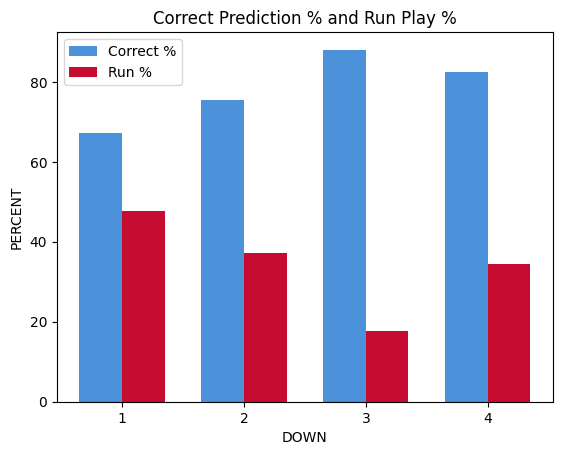

In [22]:
# Plot the correct % alongside run % based on what down it is #
titans_colors = ['#002244', '#4B92DB', '#C60C30', '#A5ACAF']
fig, ax = plt.subplots()
bar_width = 0.35
bar1 = ax.bar(down_groupings['DOWN'] - bar_width/2,
              down_groupings['Correct_%'], width=bar_width,
              label='Correct %', color=titans_colors[1])
bar2 = ax.bar(down_groupings['DOWN'] + bar_width/2,
              down_groupings['R%'], width=bar_width,
              label='Run %', color=titans_colors[2])
ax.set_xticks(down_groupings['DOWN'])
#
ax.set_xlabel('DOWN')
ax.set_ylabel('PERCENT')
ax.legend()
plt.title("Correct Prediction % and Run Play %")
plt.show()


#### Looking at the above chart you can see that 1st down was the most difficult down to correctly assess in the test data by more than 7%, this is correlated with first down also containing the most run plays by more than 10% over other downs in the total dataset.
#### Going back to the model accuracy this is why to me improving the accuracy of run play classification is most important because it will likely also help improve the accuracy of first down prediction which is the most difficult down to predict.
#### Both the 3rd and 4th down accuracy were higher than 85% which speaks to how well the model performs when it has more context to use compared to 1st down which is the most unpredictable. If I did further work on this it would be interesting to have more team based stats and scouting tendencies to incorporate to this dataset. Simply the labels of which team was which did not prove to be very significant, but I think closer steady of team tendencies could be useful in improving the 1st down accuracy of the model.


#### When you look at prediction based on team, there's not really any teams that stand out as be super difficult to predict. But with additional factors to consider for each team I think that could change. 

In [23]:
# Look at prediction by down based on additional factors #
team_groupings = recap_df.groupby(
    ['OffTeam'])['PRED_SCORE'].value_counts().unstack(fill_value=0).reset_index()
team_groupings = team_groupings.rename(columns={0:'Incorrect', 1: 'Correct'})
team_groupings['Total'] = team_groupings['Incorrect'] + team_groupings['Correct']
team_groupings['Correct_%'] = (team_groupings['Correct'] / team_groupings['Total']) \
                              * 100
print("Prediction % By Team:\n",team_groupings['Correct_%'].describe())
# Look at prediction by RB+TE numbers #
off_groupings = recap_df.groupby(
    ['RB_TE_sum'])['PRED_SCORE'].value_counts().unstack(fill_value=0).reset_index()
off_groupings = off_groupings.rename(columns={0:'Incorrect', 1: 'Correct'})
off_groupings['Total'] = off_groupings['Incorrect'] + off_groupings['Correct']
off_groupings['Correct_%'] = (off_groupings['Correct'] / off_groupings['Total']) \
                             * 100
off_groupings['Personnel_Freq_%'] = (off_groupings['Total'] /
                                     off_groupings['Correct_%'])
#print(off_groupings['Correct_%'].describe())

Prediction % By Team:
 count    32.000000
mean     74.494474
std       3.053983
min      68.211921
25%      72.600203
50%      74.600414
75%      75.866572
max      82.352941
Name: Correct_%, dtype: float64


#### Next I plotted the sum of RBs and TEs that were in on a given play.

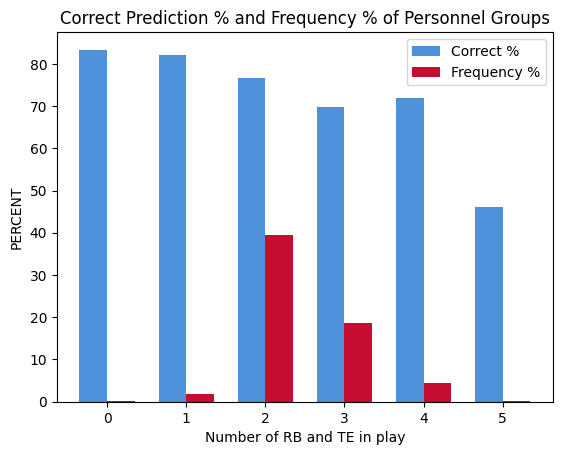

In [24]:
# Plot correct % and frequency % based on personnel groups #
fig, ax = plt.subplots()
bar1 = ax.bar(off_groupings['RB_TE_sum'] - bar_width/2,
              off_groupings['Correct_%'], width=bar_width,
              label='Correct %', color=titans_colors[1])
bar2 = ax.bar(off_groupings['RB_TE_sum'] + bar_width/2,
              off_groupings['Personnel_Freq_%'], width=bar_width,
              label='Frequency %', color=titans_colors[2])
ax.set_xticks(off_groupings['RB_TE_sum'])
#
ax.set_xlabel('Number of RB and TE in play')
ax.set_ylabel('PERCENT')
ax.legend()
plt.title("Correct Prediction % and Frequency % of Personnel Groups")
plt.show()

#### What sticks out the most from this chart is in addition to the large percentage of plays that either have 2 or 3 RBs or TEs on the field, the personnel with 3 had a prediction accuracy about 7% lower than the personnel with 2 in the test dataset. This is once again likely because personnel with 3 RBs or TEs is likely very run heavy and as we've seen the model is not as good at classifying run plays as passing plays.
#### Cases of 0 or 5 were very rare in the dataset.

# Closing


#### Assuming the end goal is to use modeling to help inform defensive play calling, improving the run play classification and first down accuracy is the most important in my opinion because that is also likely the down where the play callers could use the most help. The model does very well on other downs because it is aware of down and distance pointers just like the coaching staff is. Being able to gain any slight edge on first down would be very valuable because winning that down makes predicting the offenses future attacks easier.
#### If I were to continue working on this project I would aim to see how prescriptive a model could get in regard to what area of the field a team is likely to attack on a given run or pass play. I would also aim to incorporate additional data to help add a stronger team component to the model predictions.
#### Overall this was an interesting project to work on. It was encouraging to see some engineered features be highly ranking in model importance as well as be able to take away a good portion of the predictors and have the model accuracy only slightly diminish. This will be valuable to future endeavors as we look to add additional data to this model and don't want the amount of variables to get too large. Overall, by using only pre-snap factors the random forest model was able to accurately predict if a play would be a run or pass in the majority of situations while not using an excessive amount of predictors.